# This is the Deep Learning solution transformer fase of the project!
### First we intalled tf-keras and transformers because of some version issues. 

In [3]:
pip install tf-keras

In [ ]:
pip install accelerate torch transformers

In [21]:
pip install evaluate

Note: you may need to restart the kernel to use updated packages.


### Here we set the environments. 

In [6]:
import pandas as pd
import tensorflow as tf
from transformers import pipeline
import re
import numpy as np
from nltk.tokenize import word_tokenize
from transformers import AutoTokenizer
from transformers import EarlyStoppingCallback
from evaluate import load
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### Loading the dataset. 

In [9]:
df = pd.read_csv("data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv")

### First, let's start with the tokenization of the data to remove special characters.

In [12]:
def clean_and_tokenize(text):
    if isinstance(text, str):
        text = re.sub(r"[^a-zA-Z\s]", "", text)
        text = text.lower()
        tokens = text.split()
        return " ".join(tokens)
    return ""

df["cleaned_reviews"] = df["reviews.text"].apply(clean_and_tokenize)

print(df[["reviews.text", "cleaned_reviews"]].head())

                                        reviews.text  \
0  I thought it would be as big as small paper bu...   
1  This kindle is light and easy to use especiall...   
2  Didnt know how much i'd use a kindle so went f...   
3  I am 100 happy with my purchase. I caught it o...   
4  Solid entry level Kindle. Great for kids. Gift...   

                                     cleaned_reviews  
0  i thought it would be as big as small paper bu...  
1  this kindle is light and easy to use especiall...  
2  didnt know how much id use a kindle so went fo...  
3  i am happy with my purchase i caught it on sal...  
4  solid entry level kindle great for kids gifted...  


### Then we work on applying the tokenization using the tokenizer with the HuggingFace Transformers. 
### The text data is converted into input tokens suitable for model input. 

In [15]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_text(text):
    if isinstance(text, str):
        return tokenizer.encode(text, truncation=True, padding="max_length", max_length=128)
    return []

df["tokenized_reviews"] = df["reviews.text"].apply(tokenize_text)

df.to_csv("tokenized_reviews.csv", index=False)
print(df[["reviews.text", "tokenized_reviews"]].head())

                                        reviews.text  \
0  I thought it would be as big as small paper bu...   
1  This kindle is light and easy to use especiall...   
2  Didnt know how much i'd use a kindle so went f...   
3  I am 100 happy with my purchase. I caught it o...   
4  Solid entry level Kindle. Great for kids. Gift...   

                                   tokenized_reviews  
0  [101, 1045, 2245, 2009, 2052, 2022, 2004, 2502...  
1  [101, 2023, 2785, 2571, 2003, 2422, 1998, 3733...  
2  [101, 2134, 2102, 2113, 2129, 2172, 1045, 1005...  
3  [101, 1045, 2572, 2531, 3407, 2007, 2026, 5309...  
4  [101, 5024, 4443, 2504, 2785, 2571, 1012, 2307...  


### After that, we encode the tokenize input sequences into numerical IDs using the tokenizer's vocabulary.

In [18]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def encode_text(text):
    if isinstance(text, str):
        tokens = tokenizer(text, truncation=True, padding="max_length", max_length=128, return_tensors="pt")
        return tokens["input_ids"].squeeze().tolist()  # Convert tensor to list
    return []

df["encoded_reviews"] = df["reviews.text"].apply(encode_text)

df.to_csv("encoded_reviews.csv", index=False)
print(df[["reviews.text", "encoded_reviews"]].head())

                                        reviews.text  \
0  I thought it would be as big as small paper bu...   
1  This kindle is light and easy to use especiall...   
2  Didnt know how much i'd use a kindle so went f...   
3  I am 100 happy with my purchase. I caught it o...   
4  Solid entry level Kindle. Great for kids. Gift...   

                                     encoded_reviews  
0  [101, 1045, 2245, 2009, 2052, 2022, 2004, 2502...  
1  [101, 2023, 2785, 2571, 2003, 2422, 1998, 3733...  
2  [101, 2134, 2102, 2113, 2129, 2172, 1045, 1005...  
3  [101, 1045, 2572, 2531, 3407, 2007, 2026, 5309...  
4  [101, 5024, 4443, 2504, 2785, 2571, 1012, 2307...  


### Finally, we inplement the sentiment into the data set with it's calculations. 

In [5]:
df.to_csv("Transformer_Sentiment_Results.csv")

NameError: name 'df' is not defined

In [20]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_text(text):
    if isinstance(text, str):
        return tokenizer.encode(text, truncation=True, padding="max_length", max_length=128)
    return []

df["tokenized_reviews"] = df["reviews.text"].apply(tokenize_text)

df.to_csv("tokenized_reviews.csv", index=False)  # Save tokenized data
print(df[["reviews.text", "tokenized_reviews"]].head())  # Print first few rows for verification

                                        reviews.text  \
0  I thought it would be as big as small paper bu...   
1  This kindle is light and easy to use especiall...   
2  Didnt know how much i'd use a kindle so went f...   
3  I am 100 happy with my purchase. I caught it o...   
4  Solid entry level Kindle. Great for kids. Gift...   

                                   tokenized_reviews  
0  [101, 1045, 2245, 2009, 2052, 2022, 2004, 2502...  
1  [101, 2023, 2785, 2571, 2003, 2422, 1998, 3733...  
2  [101, 2134, 2102, 2113, 2129, 2172, 1045, 1005...  
3  [101, 1045, 2572, 2531, 3407, 2007, 2026, 5309...  
4  [101, 5024, 4443, 2504, 2785, 2571, 1012, 2307...  


### trianing model

In [25]:
df = df[['reviews.text', 'reviews.rating']].dropna()

df['label'] = df['reviews.rating'].apply(lambda x: 0 if x <= 2 else (1 if x == 3 else 2))

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['reviews.text'], df['label'], test_size=0.2, random_state=42
)

train_data = Dataset.from_dict({'text': train_texts.tolist(), 'label': train_labels.tolist()})
test_data = Dataset.from_dict({'text': test_texts.tolist(), 'label': test_labels.tolist()})

model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

from evaluate import load
import numpy as np

accuracy_metric = load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

train_data = train_data.map(tokenize_function, batched=True)
test_data = test_data.map(tokenize_function, batched=True)

training_args = TrainingArguments(
    output_dir="./bert_sentiment",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16, 
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    warmup_ratio=0.1, 
    lr_scheduler_type="linear", 
    fp16=True, 
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

from transformers import EarlyStoppingCallback
trainer.add_callback(EarlyStoppingCallback(
    early_stopping_patience=2, 
    early_stopping_threshold=0.01
))

trainer.train()

model.save_pretrained("fine_tuned_bert")
tokenizer.save_pretrained("fine_tuned_bert")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

2025/01/31 13:55:03 ERROR mlflow.utils.async_logging.async_logging_queue: Run Id a5701754ec6147ef90d2da69c773bde9: Failed to log run data: Exception: Changing param values is not allowed. Param with key='id2label' was already logged with value='{0: 'LABEL_0', 1: 'LABEL_1'}' for run ID='a5701754ec6147ef90d2da69c773bde9'. Attempted logging new value '{0: 'LABEL_0', 1: 'LABEL_1', 2: 'LABEL_2'}'.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.205100,0.176505,0.940000


('fine_tuned_bert\\tokenizer_config.json',
 'fine_tuned_bert\\special_tokens_map.json',
 'fine_tuned_bert\\vocab.txt',
 'fine_tuned_bert\\added_tokens.json',
 'fine_tuned_bert\\tokenizer.json')

### Accuracy and losses and model.

 Model achieved an accuracy of 94.00% on the validation dataset.

 Precision, Recall, and F1-score per class:
Class Negative (Label=0): Precision=34.00%, Recall=70.83%, F1-score=45.95%
Class Neutral (Label=1): Precision=100.00%, Recall=5.13%, F1-score=9.76%
Class Positive (Label=2): Precision=97.15%, Recall=98.29%, F1-score=97.72%


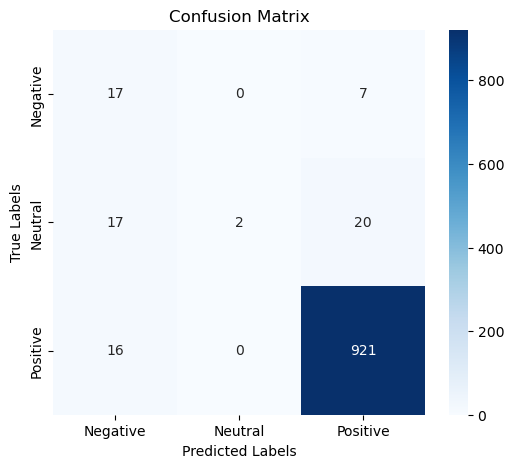

In [27]:
predictions = trainer.predict(test_data)

logits = predictions.predictions
true_labels = test_data["label"]

predicted_labels = np.argmax(logits, axis=-1)

accuracy = accuracy_score(true_labels, predicted_labels) * 100

num_classes = len(set(true_labels))  
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average=None)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

print(f" Model achieved an accuracy of {accuracy:.2f}% on the validation dataset.")

print("\n Precision, Recall, and F1-score per class:")
class_labels = ["Negative", "Neutral", "Positive"] 

for i in range(num_classes):
    print(f"Class {class_labels[i]} (Label={i}): Precision={precision[i]:.2%}, Recall={recall[i]:.2%}, F1-score={f1[i]:.2%}")

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels[:num_classes],
            yticklabels=class_labels[:num_classes])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()